In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Data Preprocessing

In [2]:
df = pd.read_excel('Online Retail.xlsx')

In [3]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


##### Invoice : 주문번호, 'C'로 시작하는 것은 취소
##### StockCode : 제품코드
##### Description : 제품 설명
##### Quantity : 주문 제품 건수
##### InvoiceDate : 주문 일자
##### UnitPrice : 제품 단가
##### CustomerID : 고객 번호
##### Country : 국가명

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df = df[df['CustomerID'].notnull()]

In [6]:
df.shape

(397884, 8)

In [7]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Country Filtering

In [8]:
df['Country'].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [9]:
df = df[df['Country']=='United Kingdom']

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354321 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354321 non-null  object        
 1   StockCode    354321 non-null  object        
 2   Description  354321 non-null  object        
 3   Quantity     354321 non-null  int64         
 4   InvoiceDate  354321 non-null  datetime64[ns]
 5   UnitPrice    354321 non-null  float64       
 6   CustomerID   354321 non-null  float64       
 7   Country      354321 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB


In [11]:
df['sale_amount'] = df['Quantity'] * df['UnitPrice']

In [12]:
df['CustomerID'] = df['CustomerID'].astype(int)

### Groupby, Aggregation

In [13]:
aggregation = {
    'InvoiceDate' : 'max',
    'InvoiceNo' : 'count',
    'sale_amount' : 'sum'
}

In [14]:
cust_df = df.groupby('CustomerID').agg(aggregation)

In [15]:
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                   'InvoiceNo': 'Frequency',
                                   'sale_amount':'Monetary'})

In [16]:
cust_df = cust_df.reset_index()

In [17]:
cust_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73
3,12749,2011-12-06 09:56:00,199,4090.88
4,12820,2011-12-06 15:12:00,59,942.34


In [18]:
cust_df['Recency'] = dt.datetime(2011, 12, 10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x : x.days +1)

In [19]:
cust_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73
3,12749,4,199,4090.88
4,12820,4,59,942.34


### Distribution

In [20]:
cust_df.describe()

,CustomerID,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000,3920.000000
mean,15562.059694,92.742092,90.388010,1864.385601
std,1576.594671,99.533485,217.808385,7482.817477
min,12346.000000,1.000000,1.000000,3.750000
25%,14208.750000,18.000000,17.000000,300.280000
50%,15569.500000,51.000000,41.000000,652.280000
75%,16913.250000,143.000000,99.250000,1576.585000
max,18287.000000,374.000000,7847.000000,259657.300000


### K-Means with StandardScaler

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [22]:
X_features = cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)
kmeans = KMeans(n_clusters = 3, random_state = 0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels
print('silhouette score :', silhouette_score(X_features_scaled, labels))

silhouette score : 0.5923691942714455


In [23]:
def visualize_silhouette(cluster_lists, X_features): 

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [24]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

C:\Users\dlarh\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
C:\Users\dlarh\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


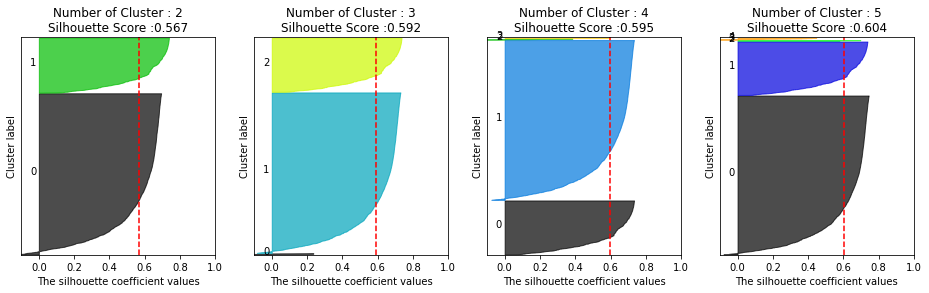

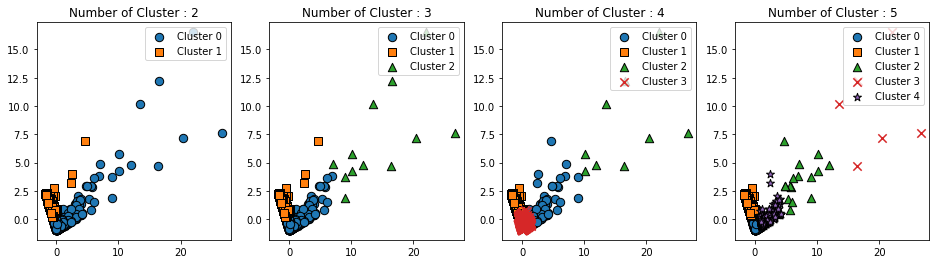

In [25]:
visualize_silhouette([2, 3, 4, 5], X_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], X_features_scaled)

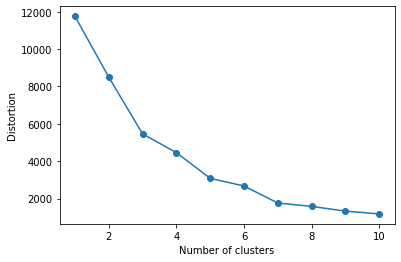

In [26]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X_features_scaled)
    distortions.append(km.inertia_) # 군집 내 분산, 적을수록 좋음

# plot - 급격하게 줄어드는 부분
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### Log Scale KMeans

In [27]:
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)
kmeans = KMeans(n_clusters = 3, random_state = 0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels
print('silhouette score :', silhouette_score(X_features_scaled, labels))

silhouette score : 0.30333901879711767


C:\Users\dlarh\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
C:\Users\dlarh\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


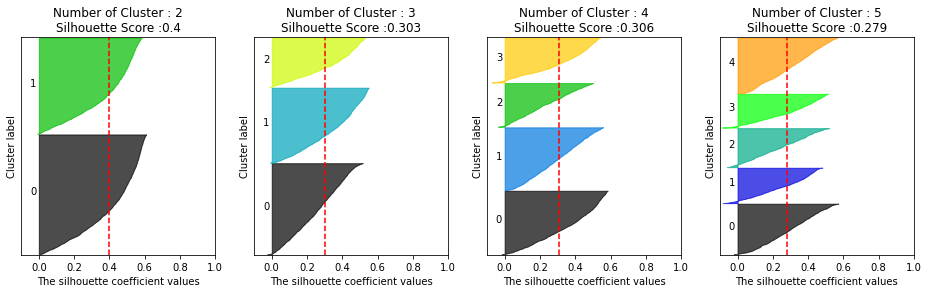

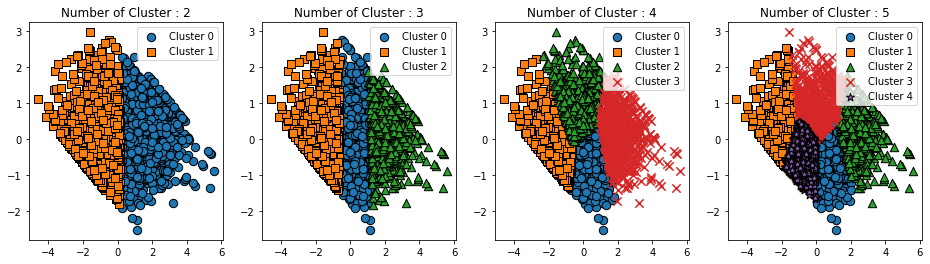

In [28]:
visualize_silhouette([2, 3, 4, 5], X_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], X_features_scaled)

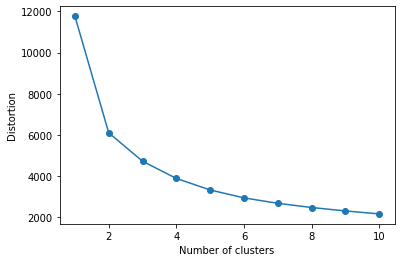

In [29]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X_features_scaled)
    distortions.append(km.inertia_) # 군집 내 분산, 적을수록 좋음

# plot - 급격하게 줄어드는 부분
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [30]:
cust_df.head()

,CustomerID,Recency,Frequency,Monetary,cluster_label,Recency_log,Frequency_log,Monetary_log
0,12346,326,1,77183.60,0,5.789960,0.693147,11.253955
1,12747,3,103,4196.01,2,1.386294,4.644391,8.342128
2,12748,1,4595,33719.73,2,0.693147,8.432942,10.425868
3,12749,4,199,4090.88,2,1.609438,5.298317,8.316760
4,12820,4,59,942.34,2,1.609438,4.094345,6.849427
